In [13]:
# Copyright 2017 The PARSE-ego4D Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import random
import json
import pandas as pd
import numpy as np
import time
import datetime

import io
import sys
import warnings

In [6]:
LM_NAME = ''
MM_NAME = ''

def load_data():
  pass

def load_clean_df():
  pass

def get_all_video_fnames():
  pass

def get_fname_to_fsize_mb():
  pass

def generate_embeddings_batch(text_list: list[str]) -> np.ndarray:
  # see https://ai.google.dev/docs/embeddings_guide
  pass

## Load data

In [14]:
df = load_data()

## Cleaning up

In [15]:
# @title Extract failed data, separate video data, clean up, remove duplicates

dfc = df.copy()

# remove unused columns
dfc.drop(columns=['Confidence', 'H', 'I', 'Assumptions', 'K'], inplace=True)

# reorder columns
cols = [
  'Video ID', 'Batch idx', 'Batch size', 'Line',
  'Query', 'Action', 'Params',
  'Thoughts', 'Description',
  'User prompt', 'Video summary',
  'Timestamp', 'Model', 'Comments',
]
dfc = dfc[cols]

# sort by video id, batch idx
dfc.sort_values(by=['Video ID', 'Batch idx'], inplace=True)

# remove failed
failed_idxs = dfc['Comments'].str.contains("Failed")
df_failed = dfc[failed_idxs]
df_failed = df_failed.drop(columns=[c for c in df_failed.columns if c not in ['Video ID', 'Model', 'Comments']])
dfc = dfc[~failed_idxs]

# remove empty -> merge into failed
print('dividing into failed and successful samples')
empty_idxs = ((dfc['Action'].str.strip() == "") | (dfc['Params'].str.strip() == "") | (dfc['Query'].str.strip() == ""))
df_failed = pd.concat([df_failed, dfc[empty_idxs]])
dfc = dfc[~empty_idxs]
print(f"error: {df_failed.shape[0]:,}, success: {dfc.shape[0]:,} (total: {df.shape[0]:,})")
print()

# clean up the model names
dfc.loc[:, 'Model'] = dfc['Model'].str.strip().replace(LM_NAME, 'lm_it_m')
dfc.loc[:, 'Model'] = dfc['Model'].str.strip().replace(MM_NAME, 'mm_it_m')
df_failed.loc[:, 'Model'] = df_failed['Model'].str.strip().replace(LM_NAME, 'lm_it_m')
df_failed.loc[:, 'Model'] = df_failed['Model'].str.strip().replace(MM_NAME, 'mm_it_m')

# clean up the user prompts
dfc.loc[:, 'User prompt'] = dfc['User prompt'].str.strip()

# clean up the failure modes
with warnings.catch_warnings(action="ignore"):
  df_failed.loc[df_failed['Comments'].str.contains("JSONDecodeError"), 'Comments'] = "Failed: JSON decode error"
  df_failed.loc[df_failed['Comments'].str.contains("DEADLINE_EXCEEDED"), 'Comments'] = "Failed: Context length exceeded"
  df_failed.loc[df_failed['Comments'].str.contains("PermissionDenied"), 'Comments'] = "Failed: permission denied"
  df_failed.loc[df_failed['Comments'].str.contains("Less than 50"), 'Comments'] = "Failed: video too short (<50)"

# remove videos from failures that have at least one successful sample
print('removing videos with failures if they had at least one success')
failed_vids = set(df_failed['Video ID'].unique())
success_vids = set(dfc['Video ID'].unique())
df_failed_cleaned = df_failed[~df_failed['Video ID'].isin(success_vids)]
print(f"before: {df_failed.shape[0]:,} failed suggestions,   now: {df_failed_cleaned.shape[0]:,}")
n_vids_now = len(set(df_failed_cleaned['Video ID'].unique()))
print(f"before: {len(failed_vids):,} failed unique videos, now: {n_vids_now:,}")
df_failed = df_failed_cleaned
print()

# remove duplicate failures
print('removing duplicate failures (by video id and error name)')
df_failed_nodupes = df_failed.drop_duplicates(subset=['Video ID', 'Comments'], keep='first')
# w/o comments: drop 4,951 // w/ comments: drop 4,656
print(f"dropped {df_failed.shape[0] - df_failed_nodupes.shape[0]:,} duplicates (now: {df_failed_nodupes.shape[0]:,}, before: {df_failed.shape[0]:,})")
df_failed = df_failed_nodupes
print()

# remove duplicates - only if (video_id, batch_idx, query, action, params) is the same
print('removing duplicates (by video id, batch idx, query, action, params, line?)')
CONSIDER_LINE = True
cols = ['Video ID', 'Batch idx', 'Query', 'Action', 'Params']
cols += ['Line'] if CONSIDER_LINE else []
dfc_nodupes = dfc.drop_duplicates(subset=cols, keep='first')
print(f"dropped {dfc.shape[0] - dfc_nodupes.shape[0]:,} duplicates (now: {dfc_nodupes.shape[0]:,}, before: {dfc.shape[0]:,})")
dfc = dfc_nodupes
print()

# create separate video dataframe
df_videos = dfc[['Video ID', 'Video summary']]
df_videos = df_videos.drop_duplicates(subset=['Video ID'], keep='first')

# create separate video batch dataframe
df_batches = dfc[['Video ID', 'Batch idx', 'Batch size', 'User prompt']]
df_batches = df_batches.drop_duplicates()

# remove unused columns
df_failed = df_failed.drop(columns=[c for c in df_failed.columns if c not in ['Video ID', 'Model', 'Comments']])
dfc = dfc.drop(columns=['Comments', 'Video summary', 'User prompt'])
# dfc = dfc.drop(columns=['Comments'])

# sort video, video batch and failed dataframes
df_failed = df_failed.sort_values(by=['Video ID', 'Model'])
df_videos = df_videos.sort_values(by=['Video ID'])
df_batches = df_batches.sort_values(by=['Video ID', 'Batch size', 'Batch idx'])

# reset the index for data
dfc = dfc.reset_index(drop=True)
df_failed = df_failed.reset_index(drop=True)
df_videos = df_videos.reset_index(drop=True)
df_batches = df_batches.reset_index(drop=True)
dfc.index += 1
df_failed.index += 1
df_videos.index += 1
df_batches.index += 1

# make sure there are no video IDs in df_failed that are also in the data
if len([failed_vid for failed_vid in df_failed["Video ID"].unique() if failed_vid in dfc['Video ID'].unique()]) > 0:
  print('[WARNING] video IDs in df_failed are also in data')

# print the success/failed/total video count
n_success = df_videos.shape[0]
n_failed = df_failed["Video ID"].unique().shape[0]
print(f'Successful videos: {n_success:,}')
print(f'Failed videos: {n_failed:,}')
print(f'Processed: {(n_success+n_failed)/9645:.1%}, success: {n_success/9645:.1%}, failed: {n_failed/9645:.1%}')
print()

print(f'Final shape of data:    ({dfc.shape[0]:6,}, {dfc.shape[1]:2,})')
print(f'Final shape of failed:  ({df_failed.shape[0]:6,}, {df_failed.shape[1]:2,})')
print(f'Final shape of batches: ({df_batches.shape[0]:6,}, {df_batches.shape[1]:2,})')
print(f'Final shape of videos:  ({df_videos.shape[0]:6,}, {df_videos.shape[1]:2,})')

AttributeError: 'NoneType' object has no attribute 'copy'

In [ ]:
for failure_mode in [e for e in df_failed['Comments'].unique() if e.strip()]:
  failed = df_failed[df_failed['Comments'] == failure_mode]
  print(f'{failed.shape[0]:>4}x {failure_mode.replace("Failed: ", "").lower()}')
  print(f'\t\t\t\t{tuple(sorted(failed["Video ID"].unique()))}')

1897x video too short (<50)
				('000786a7-3f9d-4fe6-bfb3-045b368f7d44', '001e3e4e-2743-47fc-8564-d5efd11f9e90', '00277df3-9107-4592-ba85-b8d054149551', '003a90b1-7960-44e2-ba2f-308ba83adc70', '003b145d-42d3-470d-b987-8a489c42f2f8', '0051a756-bce3-4cf2-adb2-3c4b5cde6711', '0089fd8c-1b30-468e-b0c9-98d265e4d705', '0090c729-7bdd-4f99-8a76-1df2c7990ab1', '00aaf182-c2c5-4891-80f1-ef01b2bc9729', '00cc4aa7-61c2-471f-9e02-c8314cfdf688', '00d31450-f87f-4868-ae99-1122a294a71d', '00eff7a7-67b4-417f-a285-82eaadc80937', '0123d797-c17d-42db-8268-53150a0641ad', '01364662-3e8c-4974-a69d-4c3bf6feb3e0', '01cab463-9a16-4817-84a4-a00ef5b7bf39', '01e63d7a-e0e9-480c-a75c-90ec00709928', '01f812c8-a0ed-42aa-8c3e-71eed10c9323', '02034aeb-0622-480d-9306-6124c2ead6d2', '0235dafb-ec68-4177-8aff-e36d6c63742d', '02497a97-5de2-469c-b2e9-c940b78c2060', '026dac2d-2ab3-4f9c-9e1d-6198db4fb080', '029532a0-3b50-457d-a790-f9dcabf93101', '02953bf3-4b5b-45ea-8339-465ed47a9337', '02c626cf-058c-444c-b1f9-5340ed8b4bd3', '02c9f4

## Remove duplicates (exact and close)

Rationale for selecting items from a list with potential duplicates:
* check if they are an exact string match - if yes, keep the first one
* check if one is contained in the other (lowercase, remove '?') - if yes, keep the shorter string (the longer one is likely a compound query - we don't want those)
* check if the embedding dot product from two queries (same video & batch) is >0.9. If so, drop the longer query.

### Exact duplicates

In [ ]:
dfc_before = dfc.copy()

In [ ]:
# drop exact string duplicates
dfc_ = dfc.drop_duplicates(subset=['Video ID', 'Batch idx', 'Query'], keep='first')
print(f'dropped {dfc.shape[0] - dfc_.shape[0]:,} exact duplicates (vid, batch_idx, query)')
dfc = dfc_.copy()
print(f'number of suggestions: {dfc.shape[0]:,}')

dropped 284 exact duplicates (vid, batch_idx, query)
number of suggestions: 24,664


In [ ]:
# drop queries that contain other queries (only for the same video ID and batch idx)
def filter_contained_queries(group):
  queries = list(group['Query'].unique())
  drop_indices = []
  for idx1, q1 in enumerate(queries):
    for idx2, q2 in enumerate(queries):
      if idx1 != idx2:
        # check if we should drop q1 -> check if q1 contains any of the q2s
        if q2.strip().lower().replace('?', '').replace('.', '') in q1.strip().lower().replace('?', '').replace('.', ''):
          drop_indices.append(idx1)
  return group.iloc[drop_indices]

grouped_df = dfc.groupby(by=['Video ID', 'Batch idx'])
grouped_df = grouped_df.filter(lambda x: x.shape[0] > 1).groupby(by=['Video ID', 'Batch idx'])
df_to_drop = grouped_df.apply(filter_contained_queries).reset_index(drop=True)
merged_df = pd.merge(dfc, df_to_drop, how='outer', indicator=True, on=df.columns.intersection(df_to_drop.columns).tolist())
dfc_ = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
print(f'dropped {df_to_drop.shape[0]:,} queries that contained another query (by vid, batch_idx)')
dfc = dfc_.copy()
print(f'number of suggestions: {dfc.shape[0]:,}')

dropped 3,176 queries that contained another query (by vid, batch_idx)
number of suggestions: 21,491


In [ ]:
# count queries with multiple questions (do not drop at this point)
dfc_ = dfc[dfc['Query'].str.count('\\?') <= 1]
print(f'detected {dfc.shape[0] - dfc_.shape[0]:,} queries with multiple questions (did not remove them)')

detected 94 queries with multiple questions (did not remove them)


### Embedding distances

In [ ]:
all_embeddings = []

In [ ]:
for idx, batch_idx in tqdm(enumerate(range(dfc.shape[0] // 100 + 1)), total=dfc.shape[0] // 100 + 1):
  if len(all_embeddings) > idx:
    continue
  a = batch_idx * 100
  b = (batch_idx+1) * 100
  b = None if b >= dfc.shape[0] else b
  batch = dfc[a:b]['Query']
  all_embeddings.append(generate_embeddings_batch(batch))

  0%|          | 0/215 [00:00<?, ?it/s]

In [ ]:
np_embeddings = np.concatenate(all_embeddings, axis=0)
np_embeddings.shape, dfc.shape

((21387, 768), (21487, 11))

In [ ]:
assert np.allclose([np.round(np_embeddings[idx] @ np_embeddings[idx], 3) for idx in range(1000)], 1), "Embeddings are not normalized!"

In [ ]:
debug_info = []

# drop queries whose similarity is large
def filter_contained_queries(group, cutoff_value=0.9, debug=True):
  queries = list(group['Query'].unique())
  embeddings = np_embeddings[group.index.tolist()]
  similarity = [[embeddings[i] @ embeddings[j] if i != j else 1.0 for i in range(len(queries))] for j in range(len(queries))]

  info = []
  drop_indices = []
  for idx1, q1 in enumerate(queries):
    for idx2, q2 in enumerate(queries):
      if idx1 < idx2:
        if similarity[idx1][idx2] > cutoff_value:
          if len(q1) > len(q2):
            drop_indices.append(idx1)
          else:
            drop_indices.append(idx2)
          info.append((group.index.tolist()[0] + idx1, q1, q2, similarity[idx1][idx2], len(q1) > len(q2)))
  if len(info) > 0:
    debug_info.append(info)
    if debug:
      print(group.index.tolist()[0], info, end='\r')
  return group.iloc[drop_indices]

# last_idx = 100
last_idx = None

grouping_cols = ['Video ID', 'Batch idx']
grouping_cols = ['Video ID']
grouped_df = dfc.reset_index()[:last_idx].groupby(by=grouping_cols)
# grouped_df = grouped_df.filter(lambda x: x.shape[0] > 1).groupby(by=['Video ID', 'Batch idx'])
df_to_drop = grouped_df.apply(filter_contained_queries).reset_index(drop=True)
merged_df = pd.merge(dfc[:last_idx], df_to_drop, how='outer', indicator=True, on=df.columns.intersection(df_to_drop.columns).tolist())
dfc_ = merged_df[merged_df['_merge'] == 'left_only'].drop('_merge', axis=1)
print(f'dropped {df_to_drop.shape[0]:,} queries that were longer than a semantically close query (by video id)')

dropped 2,757 queries that were longer than a semantically close query (by video id)


In [ ]:
dfc = dfc_.copy()
print(f'number of suggestions: {dfc[:last_idx].shape[0]:,}')

number of suggestions: 19,255


## Update the clean spreadsheet

Download the following CSV files and merge them into one spreadsheet with one sheet per file.

In [ ]:
df_failed.to_csv("df_failed.csv")
df_videos.to_csv("df_videos.csv")
dfc.to_csv("df_data.csv")
df_batches.to_csv("df_batches.csv")

## Video files

In [ ]:
loaded_video_fnames = get_all_video_fnames()
dfc = load_clean_df()
dfc['video_fname'] = dfc['Video ID'] + '-' + dfc['Line'] + '-' + dfc['Batch idx'] + '-' + dfc['Batch size'] + '.mp4'
dfc['video_loaded'] = dfc['video_fname'].apply(lambda x: x in loaded_video_fnames)

In [ ]:
n_not_loaded = dfc['video_loaded'].value_counts()[False]
n_loaded = dfc['video_loaded'].value_counts()[True]
n_total = dfc.shape[0]
print(f"Suggestions with video loaded: {n_loaded/n_total:.2%} ({n_loaded:,} / {n_total:,})")
allfnames = set(dfc['video_fname'].unique())
loadedfnames = set(loaded_video_fnames)
print(f"Loaded videos: {len(loadedfnames)/len(allfnames):.2%} ({len(loadedfnames):,} / {len(allfnames):,})")

Suggestions with video loaded: 33.14% (8,265 / 24,943)
Loaded videos: 32.21% (4,448 / 13,809)


In [ ]:
# WARNING: running this may take a long time
input('Press any key to continue')
map_fname_to_fsize_mb = get_fname_to_fsize_mb()

fsize_arr = np.array(list(map_fname_to_fsize_mb.values()))
# display statistics about file sizes (avg, std, min, max) in one line
print(f"avg: {fsize_arr.mean():.2f} MB", end=", ")
print(f"std: {fsize_arr.std():.2f} MB", end=", ")
print(f"min: {fsize_arr.min():.2f} MB", end=", ")
print(f"max: {fsize_arr.max():.2f} MB")
print(f"# files: {fsize_arr.shape[0]:,}, total: {fsize_arr.sum()/1e3:.2f} GB")

avg: 16.47 MB, std: 23.84 MB, min: 1.75 MB, max: 328.53 MB
# files: 1,176, total: 19.37 GB


# Statistics

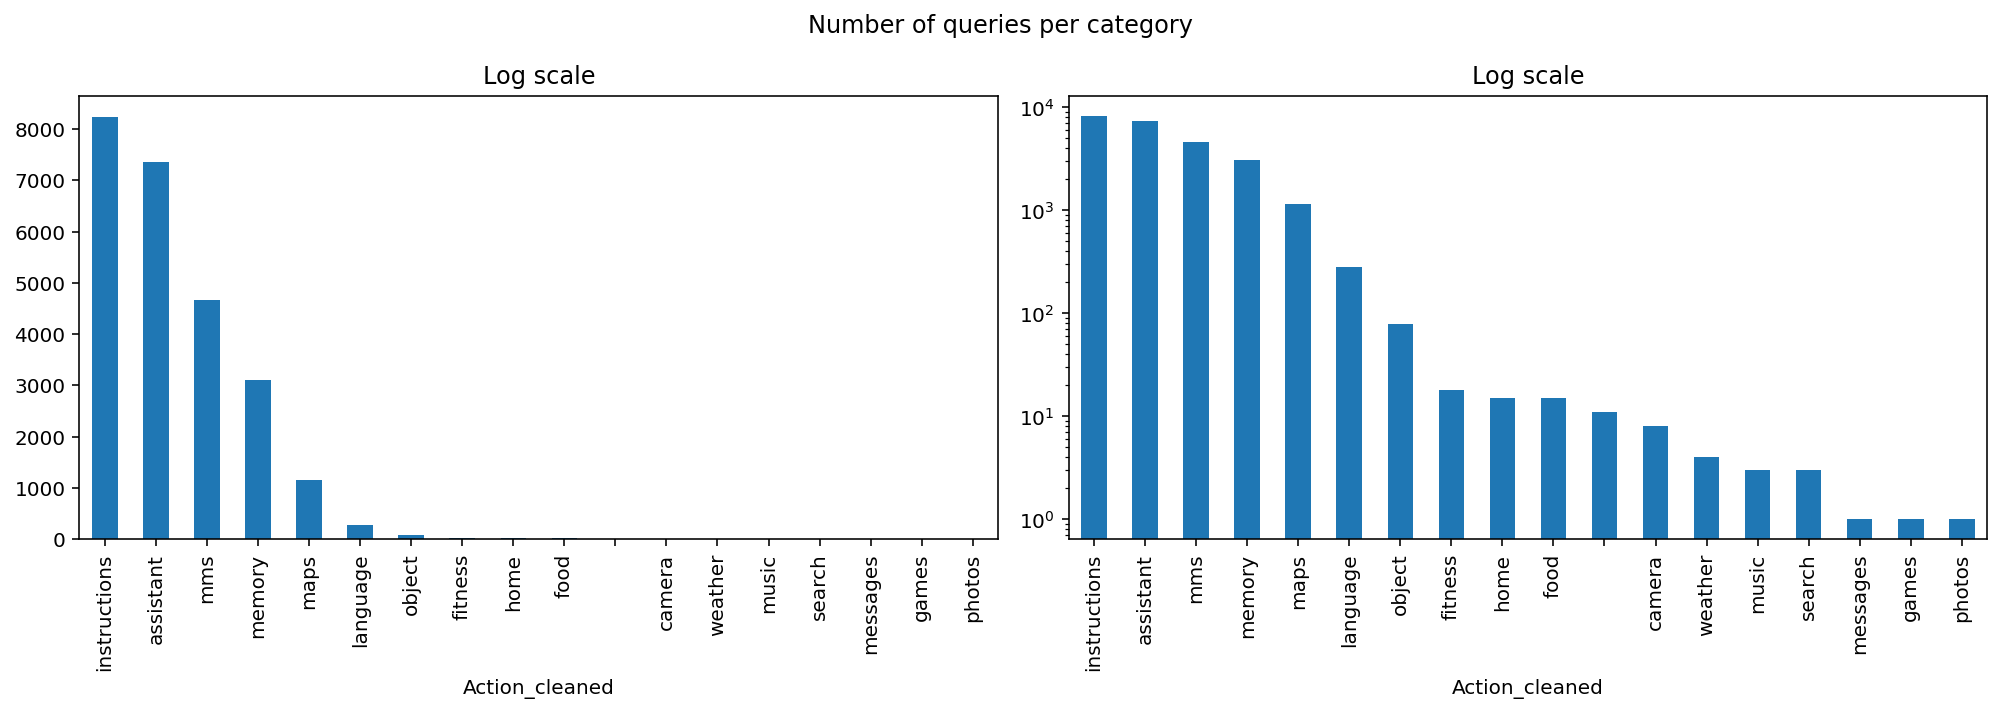

In [ ]:
dfc['Action'].unique()
dfc['Action_cleaned'] = dfc['Action'].str.strip()
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('object_centered', 'object')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('object-centered', 'object')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('generic', 'object')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('multimodal_search', 'mms')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('multimodal search', 'mms')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('multimodal', 'mms')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('smart_home', 'home')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('none', '')
dfc['Action_cleaned'] = dfc['Action_cleaned'].str.replace('N/A', '')

fig, axs = plt.subplots(ncols=2, figsize=(14, 5), dpi=300)
fig.suptitle("Number of queries per category")
dfc['Action_cleaned'].value_counts().plot(kind='bar', ax=axs[0])
dfc['Action_cleaned'].value_counts().plot(kind='bar', ax=axs[1])
axs[0].set_title('Log scale')
axs[1].set_title('Log scale')
axs[1].set_yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
dfc['Model'].unique()
# print(df_failed['Comments'].str.replace('Failed: ', '').value_counts().to_latex())
print(df_failed['Comments'].str.replace('Failed: ', '').value_counts().to_markdown())

| Comments                  |   count |
|:--------------------------|--------:|
| video too short (<50)     |    1897 |
| Failed to load narrations |    1052 |
| JSON decode error         |      90 |
| Context length exceeded   |      56 |
| permission denied         |       8 |
|                           |       1 |


In [ ]:
df.columns

Index(['Thoughts', 'Line', 'Description', 'Query', 'Action', 'Params',
       'Confidence', 'H', 'I', 'Assumptions', 'K', 'Video ID', 'Batch idx',
       'Batch size', 'Model', 'Timestamp', 'User prompt', 'Video summary',
       'Comments'],
      dtype='object')

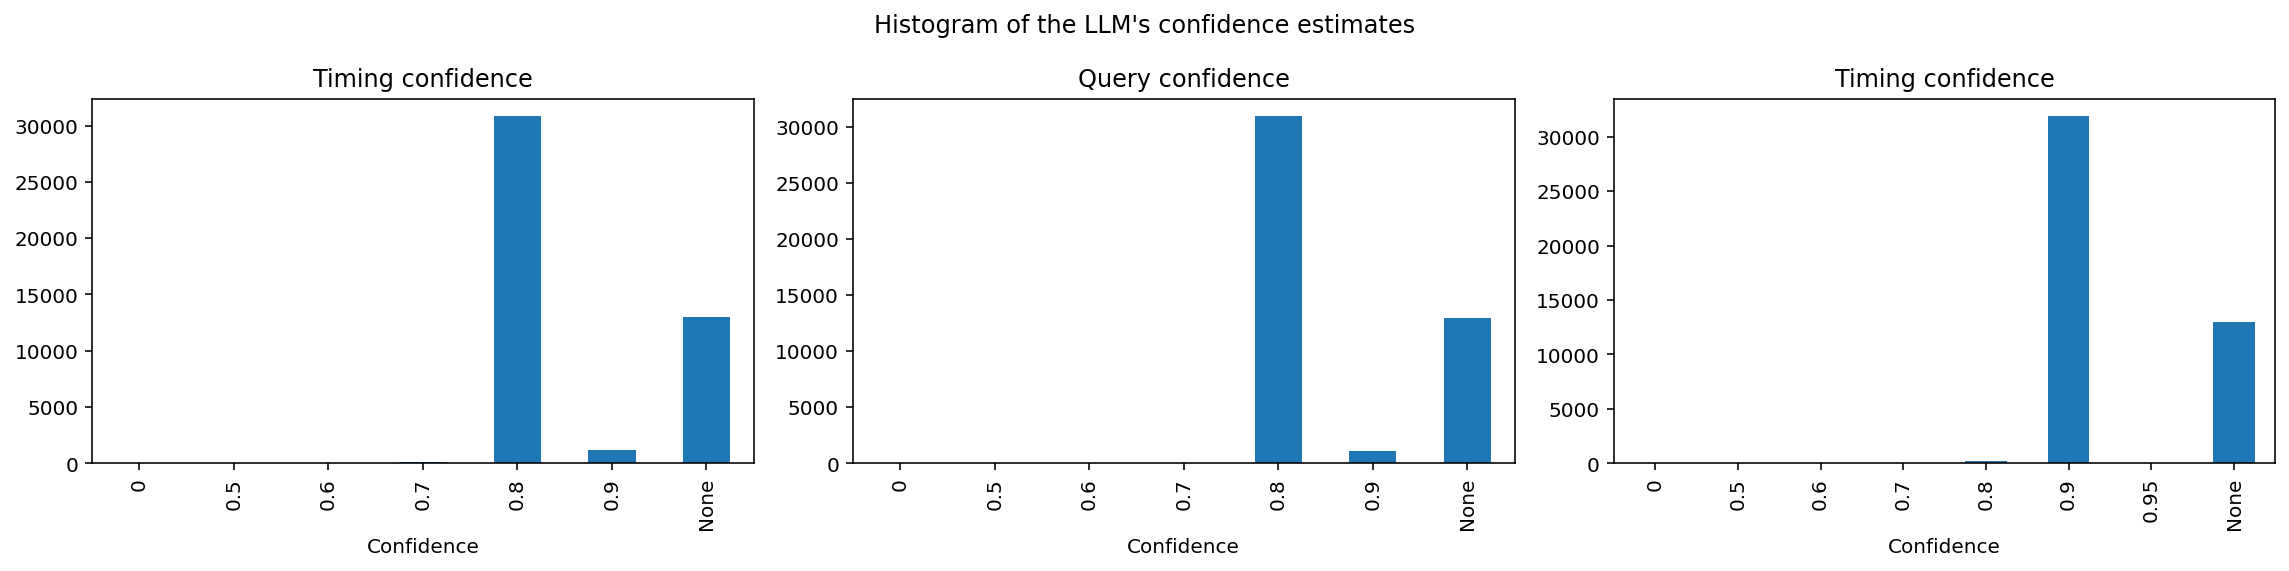

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4), dpi=300)
fig.suptitle("Histogram of the LLM's confidence estimates")
axs[0].set_title('Timing confidence')

df['Confidence'].str.replace(' ', 'None').value_counts().sort_index().plot(kind='bar', ax=axs[0])
axs[1].set_title('Query confidence')
df['H'].str.replace(' ', 'None').value_counts().sort_index().plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('Confidence')
axs[2].set_title('Timing confidence')
df['I'].str.replace(' ', 'None').value_counts().sort_index().plot(kind='bar', ax=axs[2])
axs[2].set_xlabel('Confidence')
plt.tight_layout()
plt.show()